In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

## Set-up

In [3]:
#coding:utf-8
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import copy
import sys
from segment_anything import sam_model_registry, SamPredictor


In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


## Example image

## Automatic mask generation

In [5]:

sam_checkpoint = "/home/sml/3dgs/DietGaussian/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
  

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

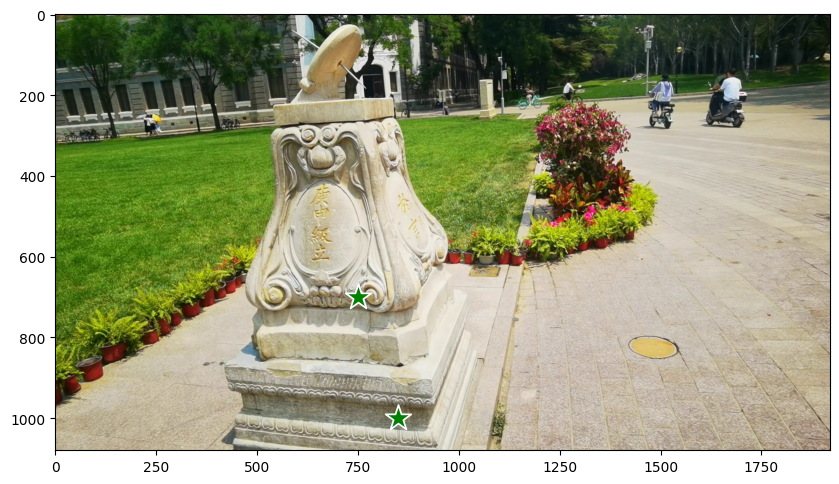

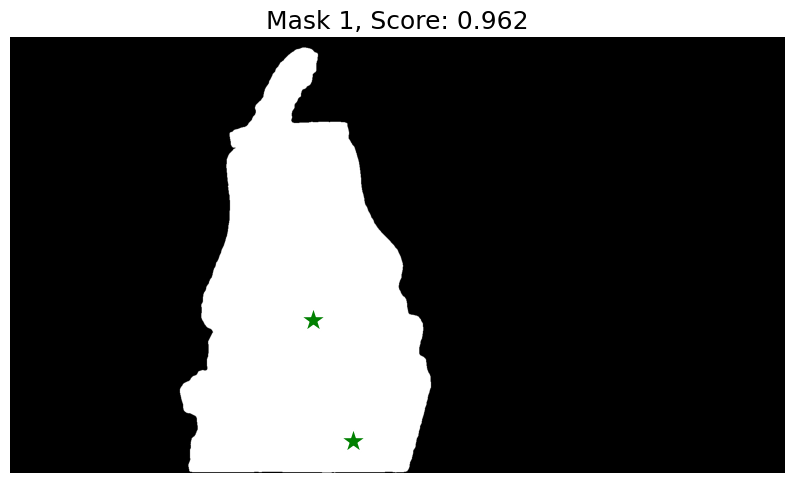

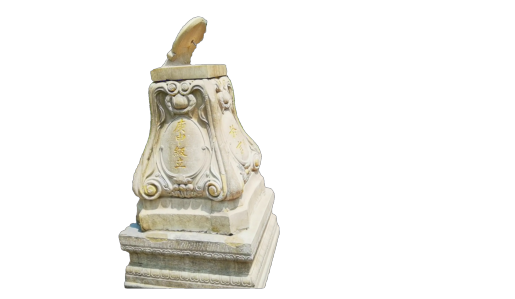

In [8]:
# 文件夹路径
folder_path = '/home/sml/3dgs/splat/tsinghua/sundial_high_resol'

# 获取文件夹中的所有文件
files = os.listdir(folder_path)

# 对每个文件进行操作
for file in files:
    # 只处理jpg文件
    if file.endswith('.jpg'):
        # 读取图像
        image_path = os.path.join(folder_path, file)
    # image_path = '/home/sml/3dgs/splat/tsinghua/sundial'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 获取文件名的基本部分
    base_name = os.path.basename(image_path)  # 返回 '2D7A1151.JPG'
    title, ext = os.path.splitext(base_name)  # 返回 '2D7A1151' 和 '.JPG'


    predictor = SamPredictor(sam)
    predictor.set_image(image)
    
    input_point = np.array([[750, 700],[850, 1000]])#(点的坐标) 
    input_label = np.array([1, 1]) 
    # print( input_point[input_label == 1])
   
    
    
    plt.figure(figsize=(10,10)) 
    plt.imshow(image) 
    
    show_points(input_point, input_label, plt.gca()) 
    
    plt.axis('on') 
    plt.show()
    
    masks, scores, logits = predictor.predict( 
        point_coords=input_point, 
        point_labels=input_label, 
        multimask_output=True, 
        )

    for i, (mask, score) in enumerate(zip(masks, scores)): 
        plt.figure(figsize=(10,10)) 
        plt.imshow(image) 
        show_mask(mask, plt.gca())
        plt.imshow(mask, cmap='gray') 
        show_points(input_point, input_label, plt.gca()) 
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18) 
        plt.axis('off') 
        plt.show() 
        break

    for i, (mask, score) in enumerate(zip(masks, scores)): 
        mask = ~mask 
        mask = mask + 255 
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2) 
        mask = mask.astype(np.uint8) 
        res = cv2.bitwise_and(image, mask) 
        res[res == 0] = 255 

        # 创建一个RGBA图像
        res_rgba = cv2.cvtColor(res, cv2.COLOR_RGB2RGBA)

        # 将mask的白色部分的alpha通道设置为0
        res_rgba[mask[:, :, 0] == 0] = [0, 0, 0, 0]

        plt.imshow(res_rgba) 
        plt.axis('off') # 关闭坐标轴 
        plt.savefig('/home/sml/3dgs/DietGaussian/segment-anything/af_sam/res-{}-{}.png'.format(title, i + 1), dpi=300, transparent=True)
        plt.show() 
        break
    
    # break